Using device: cpu
Epoch 1/100, Train MSE: 304.5691, Train MAE: 10.6482, Train R2: 0.4087, Test MSE: 487.4534, Test MAE: 14.0158, Test R2: 0.3298, Time: 0.02 seconds
Epoch 20/100, Train MSE: 148.3478, Train MAE: 8.8143, Train R2: 0.7120, Test MSE: 215.6591, Test MAE: 10.8342, Test R2: 0.7035, Time: 0.02 seconds
Epoch 40/100, Train MSE: 141.9795, Train MAE: 10.6256, Train R2: 0.7244, Test MSE: 138.1111, Test MAE: 10.0845, Test R2: 0.8101, Time: 0.02 seconds
Epoch 60/100, Train MSE: 49.2391, Train MAE: 4.8551, Train R2: 0.9044, Test MSE: 68.7637, Test MAE: 6.0608, Test R2: 0.9055, Time: 0.01 seconds
Epoch 80/100, Train MSE: 36.3616, Train MAE: 4.4916, Train R2: 0.9294, Test MSE: 45.9293, Test MAE: 5.0883, Test R2: 0.9369, Time: 0.02 seconds
Epoch 100/100, Train MSE: 30.1975, Train MAE: 4.3977, Train R2: 0.9414, Test MSE: 32.0425, Test MAE: 4.4905, Test R2: 0.9559, Time: 0.01 seconds


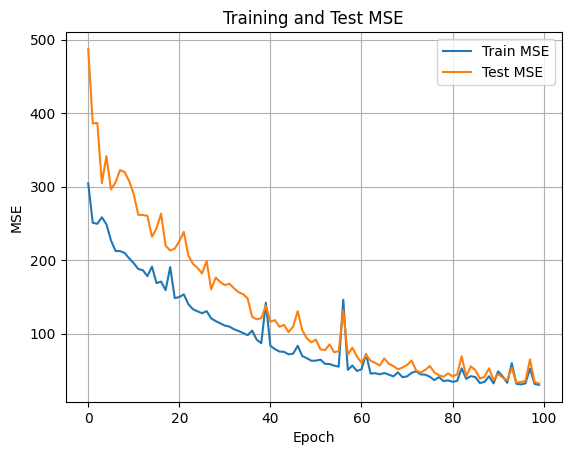

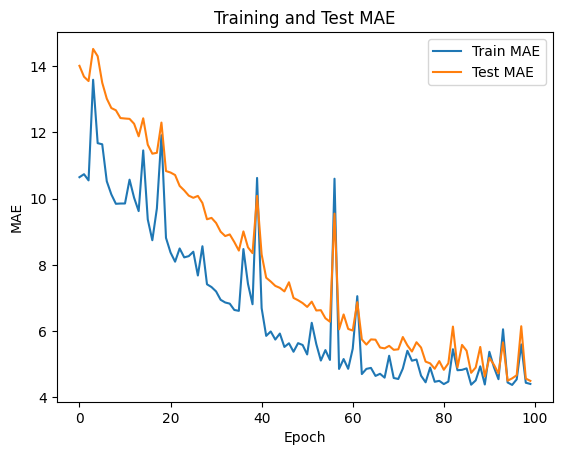

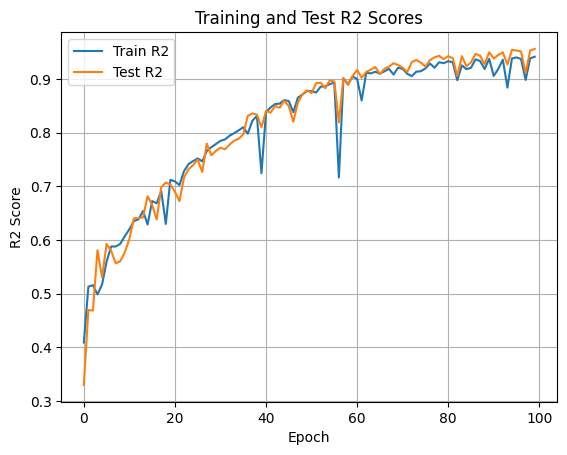

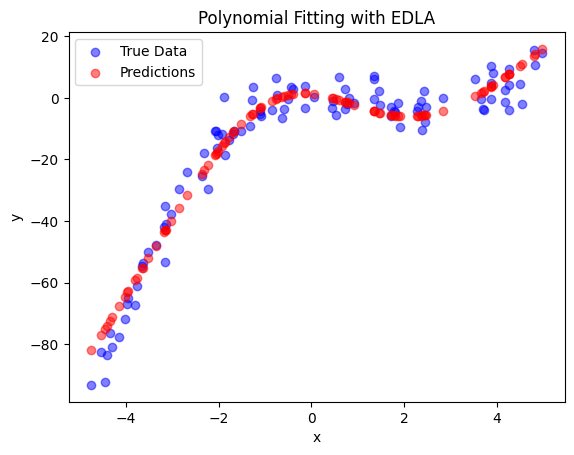

In [1]:
# -----------------------------------------------------
# Regression Task: Polynomial Fitting
# -----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from EDLA import EDLA_Multi
from criterion_reg import evaluate_model  # EDLA 用の評価関数

# -----------------------------------------------------
# Setup device
# -----------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -----------------------------------------------------
# Polynomial (Regression) Dataset Definition
# -----------------------------------------------------
# Example: y = 0.5*x^3 - 2*x^2 + x + sin(x) with added Gaussian noise
class PolynomialDataset(Dataset):
    def __init__(self, num_samples=500, noise_std=5.0):
        self.num_samples = num_samples
        # -5～5 の一様分布から x を生成
        self.x = np.random.uniform(-5, 5, num_samples)
        # 複雑な関数にノイズを加える
        self.y = 0.5 * self.x**3 - 2 * self.x**2 + self.x + np.sin(self.x) + np.random.normal(0, noise_std, num_samples)
        #self.y = np.ones(num_samples)
        #mask = self.x < 0
        #self.y[mask] = 0

        # float32 に変換して shape (N,1) に調整
        self.x = self.x.astype(np.float32).reshape(-1, 1)
        self.y = self.y.astype(np.float32).reshape(-1, 1)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])



# -----------------------------------------------------
# Set hyperparameters
# -----------------------------------------------------
num_epochs    = 100
learning_rate = 0.001
batch_size = 32

# Model parameters
input_size         = 1
hidden_size        = 1024
num_layers         = 1
output_size        = 1
activation_fn      = "Sigmoid"
# The output layer uses an identity mapping (nn.Identity) for regression tasks, so "None" is specified
last_activation_fn = "None"
loss_function      = "MSE"

# -----------------------------------------------------
# Make dataset
# -----------------------------------------------------
train_dataset = PolynomialDataset(num_samples=100, noise_std=5.0)
test_dataset = PolynomialDataset(num_samples=100, noise_std=5.0)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------------------------------
# Initialize model
# -----------------------------------------------------
model = EDLA_Multi(
    input_size         = input_size,
    hidden_size        = hidden_size,
    learning_rate      = learning_rate,
    hidden_layers      = num_layers,
    output_size        = output_size,
    activation_fn      = activation_fn,
    last_activation_fn = last_activation_fn,
    loss_fc            = loss_function
    ).to(device)

# -----------------------------------------------------
# Initialize lists to store training and testing metrics for each epoch
# -----------------------------------------------------
train_mses = np.zeros(num_epochs)
test_mses  = np.zeros(num_epochs)
train_maes = np.zeros(num_epochs)
test_maes  = np.zeros(num_epochs)
train_r2s  = np.zeros(num_epochs)
test_r2s   = np.zeros(num_epochs)

# -----------------------------------------------------
# Loop for training and testing
# -----------------------------------------------------
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Training using mini-batch
    for inputs, targets in train_loader:
        # For regression tasks, one-hot encoding is not required
        # Flatten the input if necessary
        model.update(inputs.to(device).flatten(1), targets.to(device))
        
    # Evaluate the model on the training and test datasets
    train_mse, train_mae, train_r2 = evaluate_model(model, train_loader, device)
    test_mse,  test_mae,  test_r2  = evaluate_model(model, test_loader, device)
        
    # Store the metrics for this epoch
    train_mses[epoch] = train_mse
    test_mses[epoch]  = test_mse
    train_maes[epoch] = train_mae
    test_maes[epoch]  = test_mae
    train_r2s[epoch]  = train_r2
    test_r2s[epoch]   = test_r2

       
    epoch_duration = time.time() - epoch_start_time
    
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R2: {train_r2:.4f}, Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}, Time: {epoch_duration:.2f} seconds")

# -----------------------------------------------------
# Plotting
# -----------------------------------------------------
# Plot training and test MSE, MAE, and R2 scores
plt.figure()
plt.plot(train_mses, label="Train MSE")
plt.plot(test_mses,  label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training and Test MSE")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_maes, label="Train MAE")
plt.plot(test_maes, label="Test MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Training and Test MAE")
plt.show()

plt.figure()
plt.plot(train_r2s, label="Train R2")
plt.plot(test_r2s, label="Test R2")
plt.xlabel("Epoch")
plt.ylabel("R2 Score")
plt.legend()
plt.title("Training and Test R2 Scores")
plt.grid(True)
plt.show()

# Plot the predictions
x_test = test_dataset.x
y_test = test_dataset.y

predictions = model(torch.tensor(x_test).to(device).flatten(1)).cpu().numpy()

plt.figure()
plt.scatter(x_test, y_test, label="True Data", color='blue', alpha=0.5)
plt.scatter(x_test, predictions, label="Predictions", color='red', alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Polynomial Fitting with EDLA")
plt.show()



Using device: cpu
X_train shape: (614, 8)
y_train shape: (614,)
Epoch 1/500, Train MSE: 159.3807, Train MAE: 10.4961, Train R2: -0.5588, Test MSE: 150.9241, Test MAE: 10.0816, Test R2: -0.5197, Time: 0.04 seconds
Epoch 20/500, Train MSE: 9.4838, Train MAE: 2.2921, Train R2: 0.9072, Test MSE: 10.9576, Test MAE: 2.3541, Test R2: 0.8897, Time: 0.04 seconds
Epoch 40/500, Train MSE: 8.8356, Train MAE: 2.2072, Train R2: 0.9136, Test MSE: 10.3002, Test MAE: 2.2909, Test R2: 0.8963, Time: 0.03 seconds
Epoch 60/500, Train MSE: 8.3548, Train MAE: 2.1271, Train R2: 0.9183, Test MSE: 9.7095, Test MAE: 2.2018, Test R2: 0.9022, Time: 0.04 seconds
Epoch 80/500, Train MSE: 8.0260, Train MAE: 2.0733, Train R2: 0.9215, Test MSE: 9.3987, Test MAE: 2.1582, Test R2: 0.9054, Time: 0.04 seconds
Epoch 100/500, Train MSE: 7.7527, Train MAE: 2.0311, Train R2: 0.9242, Test MSE: 9.0421, Test MAE: 2.1042, Test R2: 0.9090, Time: 0.04 seconds
Epoch 120/500, Train MSE: 7.5468, Train MAE: 1.9933, Train R2: 0.9262, Tes

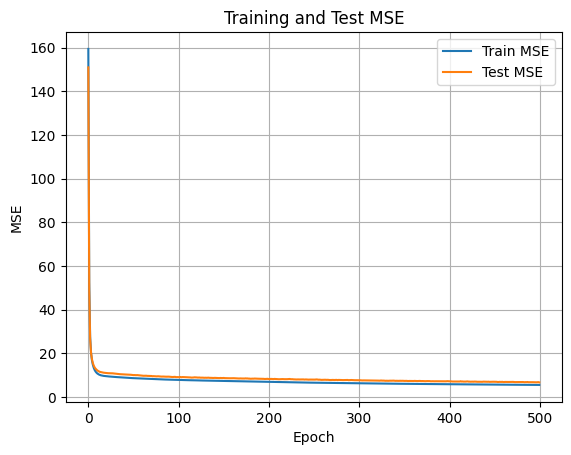

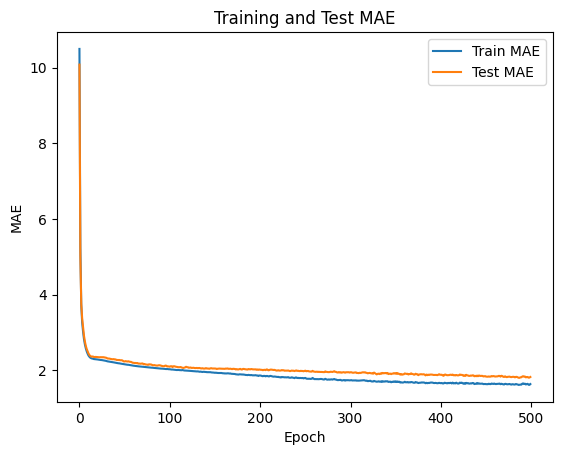

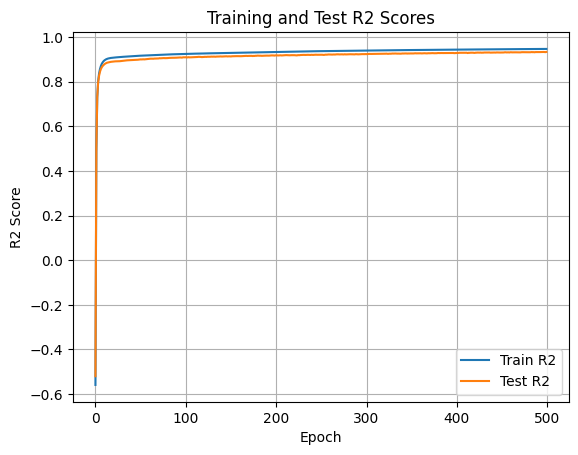

In [2]:
# -----------------------------------------------------
# Regression Task: Real-World Dataset
# -----------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset


from EDLA          import EDLA_Multi
from criterion_reg import evaluate_model
from data_reg      import load_regression_dataset

# -----------------------------------------------------
# Setup device
# -----------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# -----------------------------------------------------
# Load dataset
# -----------------------------------------------------
batch_size = 64

X_train, X_test, y_train, y_test = load_regression_dataset("energy efficiency")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# -----------------------------------------------------
# Set hyperparameters
# -----------------------------------------------------
num_epochs    = 500
learning_rate = 0.001

# Model parameters
input_size         = X_train.shape[1]
hidden_size        = 256
num_layers         = 1
output_size        = 1
activation_fn      = "Sigmoid"
# The output layer uses an identity mapping (nn.Identity) for regression tasks, so "None" is specified
last_activation_fn = "None"
loss_function      = "MSE"

# -----------------------------------------------------
# Initialize model
# -----------------------------------------------------
model = EDLA_Multi(
    input_size         = input_size,
    hidden_size        = hidden_size,
    learning_rate      = learning_rate,
    hidden_layers      = num_layers,
    output_size        = output_size,
    activation_fn      = activation_fn,
    last_activation_fn = last_activation_fn,
    loss_fc            = loss_function
    ).to(device)

# Initialize lists to store training and testing metrics for each epoch
train_mses = np.zeros(num_epochs)
test_mses  = np.zeros(num_epochs)
train_maes = np.zeros(num_epochs)
test_maes  = np.zeros(num_epochs)
train_r2s  = np.zeros(num_epochs)
test_r2s   = np.zeros(num_epochs)

# -----------------------------------------------------
# Loop for training and testing
# -----------------------------------------------------
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    # Training using mini-batch
    for inputs, targets in train_loader:
        # For regression tasks, one-hot encoding is not required
        # Flatten the input if necessary
        model.update(inputs.to(device).flatten(1), targets.to(device))
        
    # Evaluate the model on the training and test datasets
    train_mse, train_mae, train_r2 = evaluate_model(model, train_loader, device)
    test_mse,  test_mae,  test_r2  = evaluate_model(model, test_loader, device)
        
    # Store the metrics for this epoch
    train_mses[epoch] = train_mse
    test_mses[epoch]  = test_mse
    train_maes[epoch] = train_mae
    test_maes[epoch]  = test_mae
    train_r2s[epoch]  = train_r2
    test_r2s[epoch]   = test_r2

       
    epoch_duration = time.time() - epoch_start_time
    
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R2: {train_r2:.4f}, Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}, Time: {epoch_duration:.2f} seconds")


# -----------------------------------------------------
# Plotting
# -----------------------------------------------------
# Plot training and test MSE, MAE, and R2 scores
plt.figure()
plt.plot(train_mses, label="Train MSE")
plt.plot(test_mses,  label="Test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training and Test MSE")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_maes, label="Train MAE")
plt.plot(test_maes, label="Test MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.title("Training and Test MAE")
plt.show()

plt.figure()
plt.plot(train_r2s, label="Train R2")
plt.plot(test_r2s, label="Test R2")
plt.xlabel("Epoch")
plt.ylabel("R2 Score")
plt.legend()
plt.title("Training and Test R2 Scores")
plt.grid(True)
plt.show()
